In [ ]:
# required google colab installations
# !pip install torchinfo torchmetrics wandb

In [2]:
# import libraries
import random
import math
from pathlib import Path
import sys

from tqdm.auto import tqdm


import numpy as np
import matplotlib.pyplot as plt

import torchinfo # show model summary

from helpers import display_images

# pytorch modules
import torch
from torch.utils.data import DataLoader

# torch vision modules
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn

# metrics module
import torchmetrics

# tracking metrics
import wandb
# import tensorboard

In [3]:
# device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current hardware device: {DEVICE}")

Current hardware device: cuda


#### Downloading and Loading Datasets

In [4]:
# image Transforms
image_tranforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
    ])


In [5]:
# load MNIST datasets
# MNIST train data
train_data = datasets.MNIST(
    root="mnist_data",
    train=True,
    transform=image_tranforms,
    download=True,
)

# MNIST test data
test_data = datasets.MNIST(
    root="mnist_data",
    train=False,
    transform=image_tranforms,
    download=True,
)

In [6]:
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Image size: {np.array(train_data[0][0].shape)}")

Train data size: 60000
Test data size: 10000
Image size: [  3 224 224]


In [7]:
BATCH_SIZE = 32 # number of samples per mini-batches

In [8]:
# train dataloader iterable
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# test dataloader iterable
test_dataloader= DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
)

In [9]:
class_labels = train_data.classes # images class labels
print(f"class labels: {class_labels}")

class labels: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


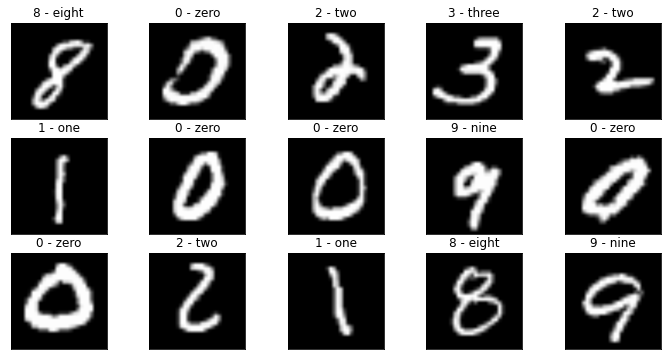

In [10]:
# display MNIST sample images
nrows, ncols = 3, 5
n_samples = nrows * ncols # number sample images to display

data, label = next(iter(train_dataloader))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,6))

for i, image in enumerate(data[:n_samples]):
    image = image.detach()[0]
    #image = image.squeeze(dim=0)
    axs[i%nrows, i//nrows].imshow(image.numpy(), cmap="gray")
    axs[i%nrows, i//nrows].set(xticks=[], yticks=[])
    axs[i%nrows, i//nrows].set_title(class_labels[label[i]])


#### Baseline Models

In [68]:
vgg_weight = torchvision.models.VGG11_Weights.IMAGENET1K_V1
vgg_model = torchvision.models.vgg11(init_weights=vgg_weight)

In [69]:
# set the output of the FC layers to number of classes of MNIST
vgg_mnist_fc = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=len(class_labels), bias=True),
)
vgg_model.classifier = vgg_mnist_fc

In [70]:
# # freezing the features layers
# for param in vgg_model.features.parameters():
#     param.requires_grad = False

In [71]:
# display model architecture
torchinfo.summary(vgg_model,
                  input_size=(32, 3, 224, 224), 
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=60,
                  row_settings=["var_names"]
                  )

Layer (type (var_name))                  Input Shape                                                  Output Shape                                                 Param #                                                      Trainable
VGG (VGG)                                [32, 3, 224, 224]                                            [32, 10]                                                     --                                                           Partial
├─Sequential (features)                  [32, 3, 224, 224]                                            [32, 512, 7, 7]                                              --                                                           False
│    └─Conv2d (0)                        [32, 3, 224, 224]                                            [32, 64, 224, 224]                                           (1,792)                                                      False
│    └─ReLU (1)                          [32, 64, 224, 224]               

##### Hyper-parameter Initialisations

In [72]:
epochs = 30 # epochs
lr = 1e-3 # learning rate

In [73]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(vgg_model.parameters(), lr=lr)

In [74]:
# metrics definition
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [78]:

for epoch in range(epochs):

    train_acc, train_loss = 0, 0
    
    vgg_model.train()
    
    for batch_data, batch_label in train_dataloader:
        batch_data = batch_data.to(DEVICE)
        batch_label = batch_label.to(DEVICE)

        pred_logits = vgg_model(batch_data)

        batch_loss = loss_fn(pred_logits, batch_label)
        train_loss += batch_loss

        preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
        
        batch_acc = accuracy_metric(preds.cpu(), batch_label.cpu()) * 100
        train_acc += batch_acc

        optimiser.zero_grad()

        batch_loss.backward()

        optimiser.step()
    
    if True:
        
        vgg_model.eval() # set model to evaluation mode
        test_loss, test_acc =  0, 0
        with torch.inference_mode():
            for batch_data, batch_label in test_dataloader:
                
                batch_data = batch_data.to(DEVICE)
                batch_label = batch_label.to(DEVICE)

                pred_logits = vgg_model(batch_data)

                batch_loss = loss_fn(pred_logits, batch_label)
                test_loss += batch_loss

                preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
                
                batch_acc = accuracy_metric(preds.cpu(), batch_label.cpu()) * 100
                test_acc += batch_acc
        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss/len(train_dataloader): .3f}\t Traning accuracy: {train_acc/len(train_dataloader): .3f}", end="\t")
        print(f"Test loss: {test_loss/len(test_dataloader): .3f}\t Test acc: {test_acc/len(test_dataloader): .3f}")



Epoch: 0
Training loss:  1.654	 Traning accuracy:  67.590	Test loss:  1.549	 Test acc:  73.532
Epoch: 1
Training loss:  1.473	 Traning accuracy:  69.847	Test loss:  1.371	 Test acc:  75.549
Epoch: 2
Training loss:  1.308	 Traning accuracy:  71.475	Test loss:  1.217	 Test acc:  76.827


KeyboardInterrupt: 

##### Model Trains

##### Visualisations

In [ ]:
torchmetrics.ConfusionMatrix